In [1]:
from skimage import measure
from skimage.transform import resize
from skimage.filters import threshold_otsu, threshold_local, threshold_isodata
from skimage.color import rgb2gray
import os
import re
import gc
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
## true or false
debug = 0

In [3]:
plot_direc = 'plot'
data_direc = 'us'
shape = (720, 1280) ## better to change
nimg = 10 if debug else 222

# image

In [14]:
def read_data():
    allimage = glob.glob(data_direc + '/*.jpg')
    image = np.empty(nimg, dtype=object)
    label = np.empty((nimg, 6), dtype=object)
    for i, image_name in enumerate(allimage):
        label_name = image_name.rsplit('.')[0] + ".txt"
        img = plt.imread(image_name)
        img = rgb2gray(img)
        image[i] = img
        with open(label_name, 'r') as f:
            txt = f.read()
        lab = txt.strip('\n').split('\t')
        label[i,:] = lab
        
        if i == nimg-1: break
    ## change type
    tmp = label[:,1:5].astype('float')
    label[:,1:5] = tmp
    
    return image, label

## reshape image to same size
def reshape_data(image, label):
    """
    Input:
        image: (nimg,) object array
        label: (nimg, 6) object array
        -- columns: image_name, width_y, height_x, width, height, number
    Output:
        image_reshape: (nimage, shape[0], shape[1]) array
        label_reshape: (nimage, 8) array
        -- columns: image_name, orig_shape0, orig_shape1, height_x, width_y, height, width, number
    """
    image_reshape = np.empty((image.shape[0], shape[0], shape[1]))
    ## new label (image_name, orig_shape0, orig_shape1, new_bb0, new_bb1, new_bb2, new_bb3, number)
    label_reshape = np.empty((label.shape[0], 8), dtype=object)
    for i in range(image.shape[0]):
        img = image[i]
        lab = label[i,:]
        image_reshape[i,:,:] = resize(img, output_shape=shape, mode='reflect',  anti_aliasing=True)
        label_reshape[i,0] = lab[0]
        label_reshape[i,1:3] = img.shape
        x_scale = shape[0] / img.shape[0]
        y_scale = shape[1] / img.shape[1]
        ## height_x, width_y, height, width 
        label_reshape[i,3:7] = [lab[2]*x_scale,lab[1]*y_scale,lab[4]*x_scale,lab[3]*y_scale]
        label_reshape[i,-1] = lab[-1]
    
    ## change to length ratio
    label_reshape[:,3] = label_reshape[:,3] / shape[0]
    label_reshape[:,4] = label_reshape[:,4] / shape[1]
    label_reshape[:,5] = label_reshape[:,5] / shape[0]
    label_reshape[:,6] = label_reshape[:,6] / shape[1]
    
    return image_reshape, label_reshape

def gray_2_binary(image):
    bin_image = np.empty(image.shape)
    for i, img in enumerate(image):
        thresh_val = threshold_otsu(img)
        bin_image[i,:,:] = img > thresh_val
    return bin_image

def draw_bb(img, lab):
    print(img.shape)
    bb = lab[-5:-1]
    fig, ax = plt.subplots()
    ax.imshow(img)
    ## (width_y, height_x, width, height)
    rect = patches.Rectangle((bb[1],bb[0]), bb[3], bb[2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [161]:
def testing_dataset(image, label):
    ## get all bounding box information
    all_bb = label[:,-5:-1]

    ## check the size of the license plate relative to the image
    x = all_bb[:,2]
    y = all_bb[:,3]
    
    print(np.percentile(x, 90) )
    print(np.percentile(y, 90) )

In [5]:
image, label = read_data()

In [6]:
image_reshape, label_reshape = reshape_data(image, label)

(720, 1280)


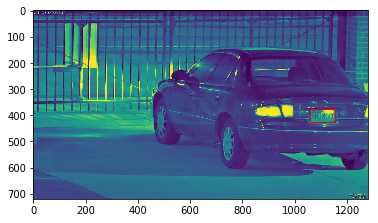

In [8]:
i = np.random.randint(nimg)
# i = 84
draw_bb(image_reshape[i], label_reshape[i])

In [23]:
## center and normalize images
img_mean = image_reshape.mean(axis=1).mean(axis=1)
img_scale

(222,)

# model

In [24]:
## keras
import keras.backend as K
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import tensorflow as tf

In [25]:
"""
taken from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/63044
"""
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def IoU(true, pred): #any shape can go - can't be a loss function
    tresholds = [0.5 + (i*.05)  for i in range(10)]
    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))
    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)
    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))
    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)
    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)
    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]
    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)
    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

In [26]:
def get_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (10,10), activation = 'relu', input_shape=(shape[0],shape[1],1)))
    model.add(Conv2D(filters = 16, kernel_size = (5,5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(4))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[IoU] )
    return model

In [ ]:
model = get_model()

early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, restore_best_weights=True)

model.fit(x=image_reshape[:,:,:,np.newaxis], y=label_reshape[:,-5:-1],
          batch_size=1, epochs=2, verbose=1,
          callbacks=[early_stopper])

Epoch 1/2
